In order to do text classification, we need to extract features from text content since machine can't read words like we do. However, there doesn't exist a single best way to generate information from context. Therefore we will try various word embedding method including bag-of-words models and vector-space models, and compare its performance by using neural network models for classfication. 

In [3]:
import os
import pandas as pd
import numpy as np
%matplotlib inline 
import string
import nltk
import gc
import gensim.models.keyedvectors as word2vec
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from keras import metrics
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, concatenate, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


First we read in the spam file and remove non informative columns consists of NaN. 

In [5]:
sms = pd.read_csv('spam.csv',encoding='latin-1')
sms = sms.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
sms = sms.rename(columns={"v1":"class", "v2":"text"})
sms.head(10)

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


We can see that the data contains two columns, the email text and class label of ham/spam. Next, we will do some basic EDA of the spam data.

In [126]:
sms.groupby('class').describe()

text                                                               
      count unique                                                top freq
class                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019EEC05D470>]],
      dtype=object)

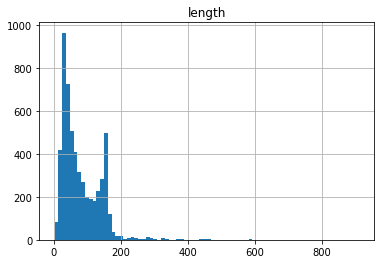

In [127]:
sms['length'] = sms['text'].apply(len)
sms.hist(column='length', bins=80)

We can see from the EDA above that the proportion of an email being ham is about 13%, and that most of the emails has length below 180 words. 

Next we will perform bag-of-word models for word embedding. Two methods we will be using are count encoding and tf-idf encoding. First we specify how many of the most common words in vocabulary we like to use, in our case it would be 1000. Then for each document, we have a 1000 dimension vector that is zero if a word appears and non-zero otherwise. For count encoding, the non-zero value is the time a word appear in document, and tf-idf is the score calculated by term frequency (raw count or term frequency) in document times log of total number of documents over the number of document which the term appears. 

In [6]:
num_max = 1000 #vocabulary size
le = LabelEncoder()
tags = le.fit_transform(sms['class'])

#one hot encoding
tok = Tokenizer(num_words=num_max)
tok.fit_on_texts(sms['text'])
count_texts = tok.texts_to_matrix(sms['text'], mode='count')
tf_idf_texts = tok.texts_to_matrix(sms['text'], mode='tfidf')
print('Encoded label of first six document')
print(tags[:6])
print('\n')
print('Count encoded matrix of first six document')
print(count_texts[:6])
print('\n')
print('Tf-idf encoded matrix of first six document')
print(tf_idf_texts[:6])
print('\n')
print('Shape of encoded label, count matrix, and tfidf matrix')
print(tags.shape,count_texts.shape, tf_idf_texts.shape)

Encoded label of first six document
[0 0 1 0 0 1]


Count encoded matrix of first six document
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 3. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 0. 2. ... 0. 0. 0.]]


Tf-idf encoded matrix of first six document
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         3.06822641 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.46707378 1.46202632 ... 0.         0.         0.        ]
 [0.         0.         2.47542574 ... 0.         0.         0.        ]]


Shape of encoded label, count matrix, and tfidf matrix
(5572,) (5572, 1000) (5572, 1000)


We will then try different type of method to encode our corpus, which is so-called vector-space models. The biggest difference comparing to bag-of-words is that vector-space models encode each word, instead of document into a fixed dimension vector. Therefore the output for each document is a matrix instead of vector. 

For our task, we will be using the famous Word2vec model, trained by CBOW and Skip-Gram models. Word2vec has serveral advantages, one is that it encodes each word into a fixed dimension vector, reducing the curse of dimension effect of large corpus in bag-of-words, another is that it is capable of preserving semantic information of words, such as Queen - Woman + Man = King, which is pretty useful in many tasks. However, Word2vec requires large amount of context to train, therefore we will be using pre-trained Googlenews word vectors.

In [5]:
# Load Google's pre-trained Word2Vec model.
word2vecDict = word2vec.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)  

After loading the pre-trained model, which is length of 300 for each word, we will then create a embedding matrix of our corpus with each word's weights corresponding to word vectors in pre-trained model of the same word. 

In [28]:
embed_size = 300
embeddings_index = dict()
for word in word2vecDict.wv.vocab:
    embeddings_index[word] = word2vecDict.word_vec(word)
print('Loaded %s word vectors.' % len(embeddings_index))            
gc.collect()

num_words = 1000
embedding_matrix = np.zeros((num_words, 300))
for word, i in tok.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
print('Embedded matrix shape :', embedding_matrix.shape)
del(embeddings_index)
gc.collect()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


Loaded 3000000 word vectors.
Embedded matrix shape : (1000, 300)


0

Now we will try to model CNN on our extracted features! The model structure of CNN is similiar to the one I described on Readme section. Since the model is intended for vector-space features, we will try with Word2vec features first. We will be using Keras, and we need to preprocess our input first. Steps for preprocessing are : For given max number (1000) of most frequent vocabulary, encode each word into an unique interger(0-999) and transfer each document into a sequence of the intergers, next we pad the sequence into length of given max length (180) with 0.

In [4]:
# preprocess for embedding layer in CNN
max_len = 180
cnn_texts_seq = tok.texts_to_sequences(sms['text'])
cnn_texts_mat = sequence.pad_sequences(cnn_texts_seq,maxlen=max_len)
print('sequence encoding of first text message')
print(cnn_texts_seq[0])
print('\n')
print('padded sequence of first text message')
print(cnn_texts_mat[0])
print('\n')
print('shape of padded sequence')
print(cnn_texts_mat.shape)

sequence encoding of first text message
[50, 469, 841, 751, 657, 64, 8, 89, 121, 349, 147, 67, 58, 144]


padded sequence of first text message
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0  50 469 841 751 657  64   8  89 121 349 147  67  58 144]


shape of padded sequence
(5572, 180)


We have 64 filters for each of bigram, trigram, and fourgram extractor, and we add a dropout layer within our dense layers to regularize our model. Another thing to mention is that we should set trainable = False for embedding layer if we are using pre-trained word vectors and we don't want the weight to be changed. 

In [36]:
#Input layer
text_input = Input(shape=(180,), dtype='int32')
#Pretrained Embedding layer
text_encoder = Embedding(1000, 300, weights=[embedding_matrix], input_length=180, trainable=False)(text_input)
#Parallel 1D convolutional layer and max pooling Layer with different kernel size
bigram_branch = Conv1D(filters=64, kernel_size=2, padding='valid', activation='relu', strides=1)(text_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=64, kernel_size=3, padding='valid', activation='relu', strides=1)(text_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=64, kernel_size=4, padding='valid', activation='relu', strides=1)(text_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
#Concat layer
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)
#Dense layer
merged = Dense(128, activation='relu')(merged)
#Dropout Layer
merged = Dropout(0.2)(merged)
merged = Dense(1)(merged)
#Output layer
output = Activation('sigmoid')(merged)
model = Model(inputs=[text_input], outputs=[output])
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 180)          0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 180, 300)     300000      input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 179, 64)      38464       embedding_6[0][0]                
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 178, 64)      57664       embedding_6[0][0]                
__________________________________________________________________________________________________
conv1d_8 (

In [37]:
np.random.seed(1337)     
history = model.fit(cnn_texts_mat,tags,batch_size=32,epochs=10,verbose=1,validation_split=0.2, shuffle=False)
print('\n')
word2vec_embed_score = max(history.history['val_acc'])
print('Best validation score : {}'.format(word2vec_embed_score))

Train on 4457 samples, validate on 1115 samples
Epoch 1/10
4457/4457 [==============================] - 26s 6ms/step - loss: 0.1421 - acc: 0.9536 - val_loss: 0.0487 - val_acc: 0.9830
Epoch 2/10
4457/4457 [==============================] - 26s 6ms/step - loss: 0.0312 - acc: 0.9915 - val_loss: 0.0540 - val_acc: 0.9794
Epoch 3/10
4457/4457 [==============================] - 26s 6ms/step - loss: 0.0153 - acc: 0.9962 - val_loss: 0.0378 - val_acc: 0.9883
Epoch 4/10
4457/4457 [==============================] - 25s 6ms/step - loss: 0.0058 - acc: 0.9991 - val_loss: 0.0420 - val_acc: 0.9874
Epoch 5/10
4457/4457 [==============================] - 25s 6ms/step - loss: 0.0033 - acc: 0.9996 - val_loss: 0.0640 - val_acc: 0.9865
Epoch 6/10
4457/4457 [==============================] - 29s 6ms/step - loss: 0.0016 - acc: 0.9998 - val_loss: 0.0440 - val_acc: 0.9865
Epoch 7/10
4457/4457 [==============================] - 27s 6ms/step - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0464 - val_acc: 0.9865
Epoch 8

For machine learning task such as regression or classification, sometimes we would like to train our embedding weight from scratch. It is slower but might result in an embedding matrix more suitable for specific dataset since the weights are now parameters that will be updated to minimize our loss function. The other setting for our model is same as above.  

In [52]:
#Input layer
text_input = Input(shape=(180,), dtype='int32')
#Embedding layer
text_encoder = Embedding(1000, 300, input_length=180, trainable=True)(text_input)
#Parallel 1D convolutional layer and max pooling Layer with different kernel size
bigram_branch = Conv1D(filters=64, kernel_size=2, padding='valid', activation='relu', strides=1)(text_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=64, kernel_size=3, padding='valid', activation='relu', strides=1)(text_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=64, kernel_size=4, padding='valid', activation='relu', strides=1)(text_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
#Concat layer
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)
#Dense layer
merged = Dense(128, activation='relu')(merged)
#Dropout Layer
merged = Dropout(0.2)(merged)
merged = Dense(1)(merged)
#Output layer
output = Activation('sigmoid')(merged)
model1 = Model(inputs=[text_input], outputs=[output])
model1.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 180)          0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 180, 300)     300000      input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 179, 64)      38464       embedding_11[0][0]               
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 178, 64)      57664       embedding_11[0][0]               
__________________________________________________________________________________________________
conv1d_23 

In [53]:
np.random.seed(1337)     
history = model1.fit(cnn_texts_mat,tags,batch_size=32,epochs=10,verbose=1,validation_split=0.2, shuffle=False)
print('\n')
nn_embed_score = max(history.history['val_acc'])
print('Best validation score : {}'.format(nn_embed_score))

Train on 4457 samples, validate on 1115 samples
Epoch 1/10
4457/4457 [==============================] - 37s 8ms/step - loss: 0.1974 - acc: 0.9313 - val_loss: 0.0592 - val_acc: 0.9812
Epoch 2/10
4457/4457 [==============================] - 33s 8ms/step - loss: 0.0313 - acc: 0.9912 - val_loss: 0.0512 - val_acc: 0.9839
Epoch 3/10
4457/4457 [==============================] - 33s 7ms/step - loss: 0.0109 - acc: 0.9973 - val_loss: 0.0547 - val_acc: 0.9848
Epoch 4/10
4457/4457 [==============================] - 32s 7ms/step - loss: 0.0042 - acc: 0.9989 - val_loss: 0.0586 - val_acc: 0.9857
Epoch 5/10
4457/4457 [==============================] - 31s 7ms/step - loss: 0.0028 - acc: 0.9993 - val_loss: 0.0603 - val_acc: 0.9848
Epoch 6/10
4457/4457 [==============================] - 34s 8ms/step - loss: 0.0017 - acc: 0.9996 - val_loss: 0.0622 - val_acc: 0.9874
Epoch 7/10
4457/4457 [==============================] - 35s 8ms/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0668 - val_acc: 0.9874
Epoch 8

Both methods reach similiar score in terms of accuracy, with Word2vec embedding slightly better. Next we will try the same model on our count and tfidf features respectively. The input shape is now (1000,1) instead of (180, 300), and we will remove the embedding layer. 

In [45]:
#Input layer
text_input = Input(shape=(1000,1), dtype='float32')
#Parallel 1D convolutional layer and max pooling Layer with different kernel size
bigram_branch = Conv1D(filters=64, kernel_size=2, padding='valid', activation='relu', strides=1)(text_input)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=64, kernel_size=3, padding='valid', activation='relu', strides=1)(text_input)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=64, kernel_size=4, padding='valid', activation='relu', strides=1)(text_input)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
#Concat layer
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)
#Dense layer
merged = Dense(128, activation='relu')(merged)
#Dropout Layer
merged = Dropout(0.2)(merged)
merged = Dense(1)(merged)
#Output layer
output = Activation('sigmoid')(merged)
model2 = Model(inputs=[text_input], outputs=[output])
model2.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 1000, 1)      0                                            
__________________________________________________________________________________________________
conv1d_31 (Conv1D)              (None, 999, 64)      192         input_15[0][0]                   
__________________________________________________________________________________________________
conv1d_32 (Conv1D)              (None, 998, 64)      256         input_15[0][0]                   
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 997, 64)      320         input_15[0][0]                   
__________________________________________________________________________________________________
global_max

In [56]:
reshaped_count_texts = count_texts.reshape((5572,1000,1))     
print('Shape of reshaped matrix')
print(reshaped_count_texts.shape)
print('\n')
np.random.seed(1337)
history = model2.fit(reshaped_count_texts,tags,batch_size=32,epochs=10,verbose=1,validation_split=0.2, shuffle=False)
print('\n')
count_score = max(history.history['val_acc'])
print('Best validation score : {}'.format(count_score))

Shape of reshaped matrix
(5572, 1000, 1)


Train on 4457 samples, validate on 1115 samples
Epoch 1/10
4457/4457 [==============================] - 39s 9ms/step - loss: 0.3902 - acc: 0.8604 - val_loss: 0.3525 - val_acc: 0.8700
Epoch 2/10
4457/4457 [==============================] - 37s 8ms/step - loss: 0.3550 - acc: 0.8649 - val_loss: 0.3453 - val_acc: 0.8700
Epoch 3/10
4457/4457 [==============================] - 38s 8ms/step - loss: 0.3506 - acc: 0.8649 - val_loss: 0.3461 - val_acc: 0.8700
Epoch 4/10
4457/4457 [==============================] - 37s 8ms/step - loss: 0.3502 - acc: 0.8649 - val_loss: 0.3414 - val_acc: 0.8700
Epoch 5/10
4457/4457 [==============================] - 38s 9ms/step - loss: 0.3486 - acc: 0.8649 - val_loss: 0.3418 - val_acc: 0.8700
Epoch 6/10
4457/4457 [==============================] - 37s 8ms/step - loss: 0.3475 - acc: 0.8649 - val_loss: 0.3408 - val_acc: 0.8700
Epoch 7/10
4457/4457 [==============================] - 38s 8ms/step - loss: 0.3487 - acc: 0.8649 -

In [53]:
reshaped_tf_idf_texts = tf_idf_texts.reshape((5572,1000,1))
np.random.seed(1337)     
history = model2.fit(reshaped_tf_idf_texts,tags,batch_size=32,epochs=10,verbose=1,validation_split=0.2, shuffle=False)
print('\n')
tf_idf_score = max(history.history['val_acc'])
print('Best validation score : {}'.format(tf_idf_score))

Train on 4457 samples, validate on 1115 samples
Epoch 1/10
4457/4457 [==============================] - 37s 8ms/step - loss: 0.4448 - acc: 0.8629 - val_loss: 0.3922 - val_acc: 0.8744
Epoch 2/10
4457/4457 [==============================] - 36s 8ms/step - loss: 0.4034 - acc: 0.8676 - val_loss: 0.3801 - val_acc: 0.8744
Epoch 3/10
4457/4457 [==============================] - 36s 8ms/step - loss: 0.3921 - acc: 0.8674 - val_loss: 0.3635 - val_acc: 0.8753
Epoch 4/10
4457/4457 [==============================] - 36s 8ms/step - loss: 0.3787 - acc: 0.8685 - val_loss: 0.3518 - val_acc: 0.8744
Epoch 5/10
4457/4457 [==============================] - 36s 8ms/step - loss: 0.3688 - acc: 0.8694 - val_loss: 0.3562 - val_acc: 0.8700
Epoch 6/10
4457/4457 [==============================] - 36s 8ms/step - loss: 0.3613 - acc: 0.8678 - val_loss: 0.3385 - val_acc: 0.8744
Epoch 7/10
4457/4457 [==============================] - 36s 8ms/step - loss: 0.3625 - acc: 0.8674 - val_loss: 0.3382 - val_acc: 0.8744
Epoch 8

Both models have bad results, which is not unexpectable. The reason is that our CNN models are intended for embedding matrix, when it is used on bag-of-words features, it is unable to capture n-gram information because the input are not ordered words. Therefore, we will model count and tf-idf features again with simple neural network instead.

In [59]:
model3 = Sequential()
model3.add(Dense(512, activation='relu', input_shape=(num_max,)))
model3.add(Dropout(0.2))
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(1, activation='sigmoid'))
model3.summary()
model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc',metrics.binary_accuracy])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 512)               512512    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 257       
Total params: 644,097
Trainable params: 644,097
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dens

In [62]:
np.random.seed(1337)
history = model3.fit(count_texts,tags,batch_size=32,epochs=10,verbose=1,validation_split=0.2, shuffle=False)
print('\n')
count_score = max(history.history['val_acc'])
print('Best validation score : {}'.format(count_score))

Train on 4457 samples, validate on 1115 samples
Epoch 1/10
4457/4457 [==============================] - 2s 503us/step - loss: 0.0035 - acc: 0.9996 - binary_accuracy: 0.9996 - val_loss: 0.0956 - val_acc: 0.9857 - val_binary_accuracy: 0.9857
Epoch 2/10
4457/4457 [==============================] - 2s 496us/step - loss: 0.0015 - acc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 0.1097 - val_acc: 0.9865 - val_binary_accuracy: 0.9865
Epoch 3/10
4457/4457 [==============================] - 2s 512us/step - loss: 0.0012 - acc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 0.1177 - val_acc: 0.9865 - val_binary_accuracy: 0.9865
Epoch 4/10
4457/4457 [==============================] - 2s 490us/step - loss: 0.0011 - acc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 0.1237 - val_acc: 0.9865 - val_binary_accuracy: 0.9865
Epoch 5/10
4457/4457 [==============================] - 2s 497us/step - loss: 9.5086e-04 - acc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 0.1285 - val_acc: 0.9865 - val_binary_accur

In [61]:
np.random.seed(1337)     
history = model3.fit(tf_idf_texts,tags,batch_size=32,epochs=10,verbose=1,validation_split=0.2, shuffle=False)
print('\n')
tf_idf_score = max(history.history['val_acc'])
print('Best validation score : {}'.format(tf_idf_score))

Train on 4457 samples, validate on 1115 samples
Epoch 1/10
4457/4457 [==============================] - 2s 511us/step - loss: 0.0013 - acc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 0.2374 - val_acc: 0.9812 - val_binary_accuracy: 0.9812
Epoch 2/10
4457/4457 [==============================] - 2s 489us/step - loss: 9.7121e-04 - acc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 0.2291 - val_acc: 0.9812 - val_binary_accuracy: 0.9812
Epoch 3/10
4457/4457 [==============================] - 2s 504us/step - loss: 9.2776e-04 - acc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 0.2292 - val_acc: 0.9803 - val_binary_accuracy: 0.9803
Epoch 4/10
4457/4457 [==============================] - 2s 490us/step - loss: 9.6891e-04 - acc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 0.2046 - val_acc: 0.9812 - val_binary_accuracy: 0.9812
Epoch 5/10
4457/4457 [==============================] - 2s 516us/step - loss: 0.0014 - acc: 0.9996 - binary_accuracy: 0.9996 - val_loss: 0.1983 - val_acc: 0.9830 - val_bina

We can see that the score improved a lot comparing to using CNN on the same features. Count features reaches a score similiar to vector-space features, while tf-idf features score a little worse. In conclusion, we learned that more complicated models does not suit all kind of data, sometimes we need to think of the problem statement before we choose our model. Further extension of this project can be testing performance on larger dataset, or using simple RNN or LSTM, which is adapted by many researchers, to do text classification.